In [ ]:
!pip install cython

In [ ]:
%load_ext Cython

# Pure Python Application

In [ ]:
import random

def euclidean_distance(point1, point2):
    return sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)) ** 0.5

def kmeans_python(data, k=3, epochs=100):
    centroids = random.sample(data, k)
    for _ in range(epochs):
        clusters = [[] for _ in range(k)]
        for point in data:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            cluster_index = distances.index(min(distances))
            clusters[cluster_index].append(point)
        for i in range(k):
            centroids[i] = [sum(dim) / len(clusters[i]) for dim in zip(*clusters[i])]
    return centroids, clusters

In [ ]:
centroids_python, clusters_python = kmeans_python(data.tolist(), k)

# Numpy/Numexpr Application

In [ ]:
import numpy as np
import numexpr as ne

def kmeans_numpy(data, k=3, epochs=100):
    n_samples, n_features = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    for _ in range(epochs):
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        closest = np.argmin(distances, axis=0)
        for i in range(k):
            centroids[i] = data[closest==i].mean(axis=0)
    return centroids

In [ ]:
centroids_numpy = kmeans_numpy(data, k)
# After computing centroids, get assignments for plotting
distances_numpy = np.sqrt(((data - centroids_numpy[:, np.newaxis])**2).sum(axis=2))
assignments_numpy = np.argmin(distances_numpy, axis=0)

# Cython Application

In [ ]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt

def euclidean_distance(np.ndarray[np.float64_t, ndim=1] point1, np.ndarray[np.float64_t, ndim=1] point2):
    cdef double distance = 0.0
    cdef int i
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return sqrt(distance)

def kmeans_cython(np.ndarray[np.float64_t, ndim=2] data, int k, int max_iterations=100):
    cdef int n = data.shape[0]
    cdef int features = data.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] centroids = np.random.rand(k, features)
    cdef np.ndarray[np.int32_t, ndim=1] assignments = np.zeros(n, dtype=np.int32)
    cdef int iteration
    for iteration in range(max_iterations):
        for i in range(n):
            min_distance = float('inf')
            for j in range(k):
                distance = euclidean_distance(data[i], centroids[j])
                if distance < min_distance:
                    min_distance = distance
                    assignments[i] = j
        for j in range(k):
            points = [data[i] for i in range(n) if assignments[i] == j]
            if points:
                centroids[j] = np.mean(points, axis=0)
    return centroids, assignments

Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_ef1c5a88ec53133ce3691cfa74b1312f736a5ad0.c:1222:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

# Test cython

In [ ]:
import numpy as np

# Generate some sample data
data = np.random.rand(300, 2)
k = 3

# Call the Cythonized KMeans function
centroids, assignments = kmeans_cython(data, k)

# Display the results
print("Centroids:", centroids)

Centroids: [[0.64333637 0.79097286]
 [0.73045381 0.29300437]
 [0.19476217 0.50194378]]


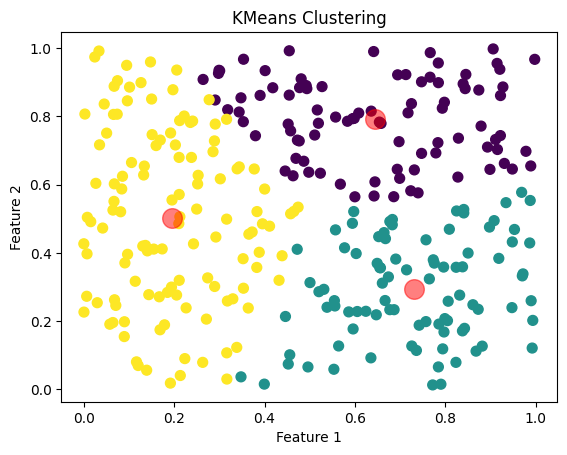

In [ ]:
import matplotlib.pyplot as plt

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], c=assignments, s=50, cmap='viridis')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)

plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [ ]:
centroids_cython, assignments_cython = kmeans_cython(data, k)

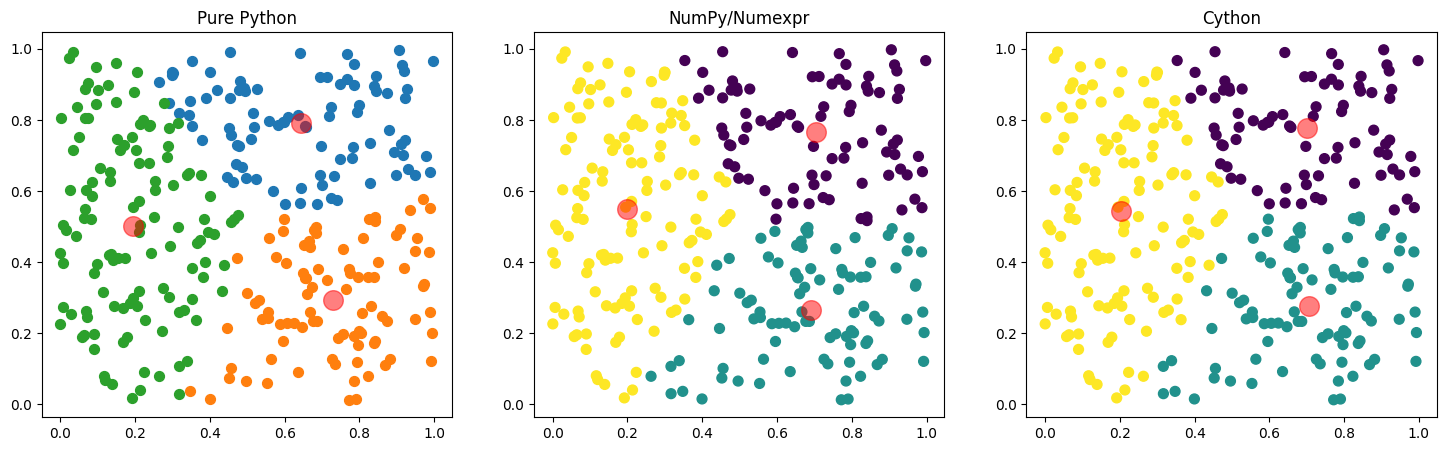

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Pure Python', 'NumPy/Numexpr', 'Cython']

# Pure Python Plot
for i, cluster in enumerate(clusters_python):
    cluster = np.array(cluster)
    axes[0].scatter(cluster[:, 0], cluster[:, 1], s=50)
axes[0].scatter(np.array(centroids_python)[:, 0], np.array(centroids_python)[:, 1], c='red', s=200, alpha=0.5)
axes[0].set_title(titles[0])

# Numpy/Numexpr Plot
axes[1].scatter(data[:, 0], data[:, 1], c=assignments_numpy, s=50, cmap='viridis')
axes[1].scatter(centroids_numpy[:, 0], centroids_numpy[:, 1], c='red', s=200, alpha=0.5)
axes[1].set_title(titles[1])

# Cython Plot
axes[2].scatter(data[:, 0], data[:, 1], c=assignments_cython, s=50, cmap='viridis')
axes[2].scatter(centroids_cython[:, 0], centroids_cython[:, 1], c='red', s=200, alpha=0.5)
axes[2].set_title(titles[2])

plt.show()

# Comparing their running times

In [ ]:
import time

# Time the Pure Python version
start_time = time.time()
centroids_python, clusters_python = kmeans_python(data.tolist(), k)
python_duration = time.time() - start_time

# Time the NumPy/Numexpr version
start_time = time.time()
centroids_numpy = kmeans_numpy(data, k)
numpy_duration = time.time() - start_time

# Time the Cython version
start_time = time.time()
centroids_cython, assignments_cython = kmeans_cython(data, k)
cython_duration = time.time() - start_time

print(f"Pure Python: {python_duration} seconds")
print(f"NumPy/Numexpr: {numpy_duration} seconds")
print(f"Cython: {cython_duration} seconds")

Pure Python: 0.2940640449523926 seconds
NumPy/Numexpr: 0.029269695281982422 seconds
Cython: 0.17444658279418945 seconds


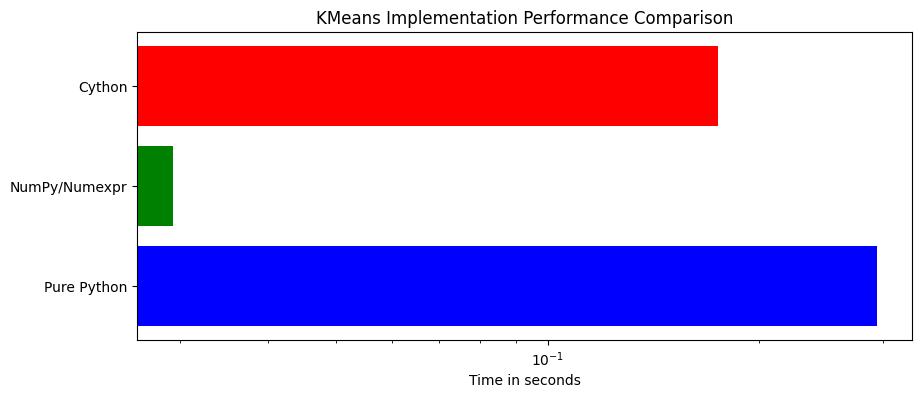

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.barh(algorithms, durations, color=['blue', 'green', 'red'])
plt.xlabel('Time in seconds')
plt.title('KMeans Implementation Performance Comparison')
plt.xscale('log')  # Useful if one method is much faster than the others
plt.show()